In [1]:
#pip install importnb

In [1]:
# This notebook executes the training routines of the agent(s) 
import random
import time
from importnb import Notebook
with Notebook():
    import Board
    import Agent
from abc import ABC, abstractmethod
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#### Parent Class ####

In [3]:
class Game(ABC):
    def __init__(self, board, agent1):
        """
        clase abstracta Game
        """
        self.board = board
        self.agent1 = agent1

    def reset_game(self):
        self.board.reset()

    @abstractmethod
    def play(self):
        pass # To be implemented by the child classes

In [7]:
#### Child Classes ####

In [9]:
class AgentVsAgent(Game):
    def __init__(self, board, agent1, agent2, epochs = 1):
        super().__init__(board, agent1)
        self.epochs = epochs
        self.agent2 = agent2
        if agent1.chip == agent2.chip:
            raise ValueError("Los agentes deben tener fichas diferentes")

    def plot_results(self, metrics):
        df = pd.DataFrame(metrics)
        
        # Contar las victorias y empates para cada jugador
        df['Jugador 1 Ganadas'] = df['Jugador 1'].apply(lambda x: 1 if x == 'G' else -1)
        df['Jugador 2 Ganadas'] = df['Jugador 2'].apply(lambda x: 1 if x == 'G' else -1)
        df['Empatadas'] = df['Jugador 2'].apply(lambda x: 0 if x == 'E' else -1)
        
        # Agrupar los resultados por Epoca y sumar las victorias y empates
        df_grouped = df.groupby('Epoca')[['Jugador 1 Ganadas', 'Jugador 2 Ganadas', 'Empatadas']].sum()
        
        # Graficar el timechart
        plt.figure(figsize=(10, 6))
        plt.plot(df_grouped.index, df_grouped['Jugador 1 Ganadas'], label='Jugador 1 - Ganadas', color='green', marker='o')
        plt.plot(df_grouped.index, df_grouped['Jugador 2 Ganadas'], label='Jugador 2 - Ganadas', color='blue', marker='o')
        plt.plot(df_grouped.index, df_grouped['Empatadas'], label='Empatadas', color='orange', marker='o')
        
        # Personalización del gráfico
        plt.title('Evolución de Partidas Ganadas y Empatadas entre Jugador 1 y Jugador 2')
        plt.xlabel('Epoca')
        plt.ylabel('Cantidad de Partidas')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_results_by_bar(self, metrics):
        print(metrics)
        df = pd.DataFrame(metrics)
        
        # Crear un DataFrame con los resultados filtrados
        resultados = pd.DataFrame({
            'Jugador 1': df['Jugador 1'].value_counts().loc[['G']].fillna(0),
            'Jugador 2': df['Jugador 2'].value_counts().loc[['G']].fillna(0),
            'Empatadas': df['Jugador 1'].value_counts().get('E', 0)
        })
        
        # Graficar solo las partidas ganadas y empatadas
        resultados.plot(kind='bar', color=['green', 'blue', 'yellow'], figsize=(8,6))
        plt.title('Partidas Ganadas y Empatadas entre Jugador 1 y Jugador 2')
        plt.xlabel('Resultado')
        plt.ylabel('Cantidad de Partidas')
        plt.xticks(rotation=0)
        plt.legend(['Jugador 1', 'Jugador 2', 'Empatadas'])
        plt.tight_layout()
        plt.show()

    def play(self, save_learning = True, plot_result = True, plot_result_by_bar = True):
        """Implementa los juegos entre los dos agentes."""
        metrics = {
            'Epoca': [],
            'Jugador 1': [],
            'Jugador 2': []
        }
        for epoch in range(self.epochs):
            start = time.time()
            self.reset_game()
            agent_1_turn = random.choice([True, False]) # randomize who gets first turn

            # An EPOCH
            while True :                
                
                if agent_1_turn:# Turno Agente 1
                    self.agent1.play_turn(episode = epoch)  
                        
                else: # Turno Agente 2
                    self.agent2.play_turn(episode = epoch)

                
                if self.board.isBoardFull() or self.board.verify_winner(self.agent1.chip) or self.board.verify_winner(self.agent2.chip):
                    break
         
                agent_1_turn = not agent_1_turn
            # END OF AN EPOCH
            j1 = ['G' if self.board.verify_winner(self.agent1.chip) else 'E' if self.board.isBoardFull() else 'P'][0]
            j2 = ['G' if self.board.verify_winner(self.agent2.chip) else 'E' if self.board.isBoardFull() else 'P'][0]
            metrics['Epoca'].append(epoch)            
            metrics['Jugador 1'].append(j1)
            metrics['Jugador 2'].append(j2)
            
            end = time.time()
            #if epoch%epoch == 0:
            print(f"Epoch # {epoch} took {(end - start):.3f} s")

        if plot_result:
            self.plot_results(metrics)
            
        if plot_result_by_bar:
            self.plot_results_by_bar(metrics)
            
        if save_learning:
            self.agent1.export_Qtable('Q_Table_A1.pkl')
            self.agent1.export_Qtable_JSON('Q_Table_A1.json')
            self.agent2.export_Qtable('Q_Table_A2.pkl')
            self.agent2.export_Qtable_JSON('Q_Table_A2.json')

In [11]:
class PlayerVsAgent(Game):
    def __init__(self, board, agent):
        super().__init__(board, agent)
        self.agent = agent
        #self.player_chip = ?
        if self.agent.chip == "X":
            self.player_chip = "O"
        else:
            self.player_chip = "X"

    def play(self):
        """Implementa un juego entre un humano y un agente."""
                
        play_again = True
        while play_again:
            
            self.reset_game()
            player_turn = random.choice([True, False]) # randomize who gets first turn
            if player_turn:
                print("You start this time")
            else:
                print("I will start this time")
            
            while True:         
                
                if player_turn:
                    # print the current state of the board
                    self.board.print_board()
                    print("It´s your turn!")

                    # Ask for the next move and place the chip
                    while True:
                        try:
                            user_input = input("What is your move? ")
                            new_col_number = int(user_input)  # Intentar convertir a entero
                            
                            # Verificar que el número esté dentro del rango permitido
                            if not (1 <= new_col_number <= 7):
                                raise ValueError("The column must be a number between 1 and 7.")
                            
                            # Intentar colocar la ficha en el tablero
                            if not self.board.place_chip(new_col_number, self.player_chip):
                                raise ValueError("Invalid move. The column might be full or invalid. Try again.")
                            
                            # Si el movimiento es válido, romper el bucle
                            break
                            
                        except ValueError as e:
                            print(e)
                            
                    if self.board.verify_winner(self.player_chip):
                        self.board.print_board()
                        print("YOU WIN!")
                        # comunicarle al agente que perdió -> asignar la recompensa 
                        break
                    elif self.board.isBoardFull():
                        self.board.print_board()
                        print("ITS A TIE")
                        # comunicarle al agente que empato -> asignar la recompensa 
                        break

                # FIN DEL TURNO DEL Jugador
                    
                else: # Agents Turn
                    
                    print("\nIt´s My turn!")
                    self.agent.play_turn()

                    if self.board.verify_winner(self.agent.chip):
                        self.board.print_board()
                        print("YOU LOSE!")
                        break
                    elif self.board.isBoardFull():
                        self.board.print_board()
                        print("ITS A TIE")
                        # comunicarle al agente que empato -> asignar la recompensa 
                        break

                
                    # FIN DEL TURNO DEL AGENTE

                player_turn = not player_turn

            # Juego terminó, preguntar si se quiere volver a jugar
            usr_input = ""
            while usr_input.lower() not in ["y", "n", "yes", "no"]:
                usr_input = input("Do you want to play again? (y/n): ").strip()

            if usr_input.lower() in ["y", "yes"]:
                play_again = True  # No es necesario redefinir, pero preferi dejarlo explícito
            elif usr_input.lower() in ["n", "no"]:
                play_again = False

        print("Thanks for playing, Bye!")

**Entrenamiento Agente VS Agente**

Epoch # 0 took 0.087 s
Epoch # 1 took 0.043 s
Epoch # 2 took 0.042 s
Epoch # 3 took 0.046 s
Epoch # 4 took 0.037 s
Epoch # 5 took 0.066 s
Epoch # 6 took 0.060 s
Epoch # 7 took 0.084 s
Epoch # 8 took 0.045 s
Epoch # 9 took 0.048 s
Epoch # 10 took 0.039 s
Epoch # 11 took 0.042 s
Epoch # 12 took 0.051 s
Epoch # 13 took 0.060 s
Epoch # 14 took 0.013 s
Epoch # 15 took 0.033 s
Epoch # 16 took 0.054 s
Epoch # 17 took 0.037 s
Epoch # 18 took 0.015 s
Epoch # 19 took 0.039 s
Epoch # 20 took 0.047 s
Epoch # 21 took 0.054 s
Epoch # 22 took 0.047 s
Epoch # 23 took 0.021 s
Epoch # 24 took 0.021 s
Epoch # 25 took 0.056 s
Epoch # 26 took 0.037 s
Epoch # 27 took 0.031 s
Epoch # 28 took 0.039 s
Epoch # 29 took 0.044 s
Epoch # 30 took 0.066 s
Epoch # 31 took 0.076 s
Epoch # 32 took 0.034 s
Epoch # 33 took 0.050 s
Epoch # 34 took 0.038 s
Epoch # 35 took 0.039 s
Epoch # 36 took 0.071 s
Epoch # 37 took 0.025 s
Epoch # 38 took 0.060 s
Epoch # 39 took 0.071 s
Epoch # 40 took 0.017 s
Epoch # 41 took 0.091 s
Ep

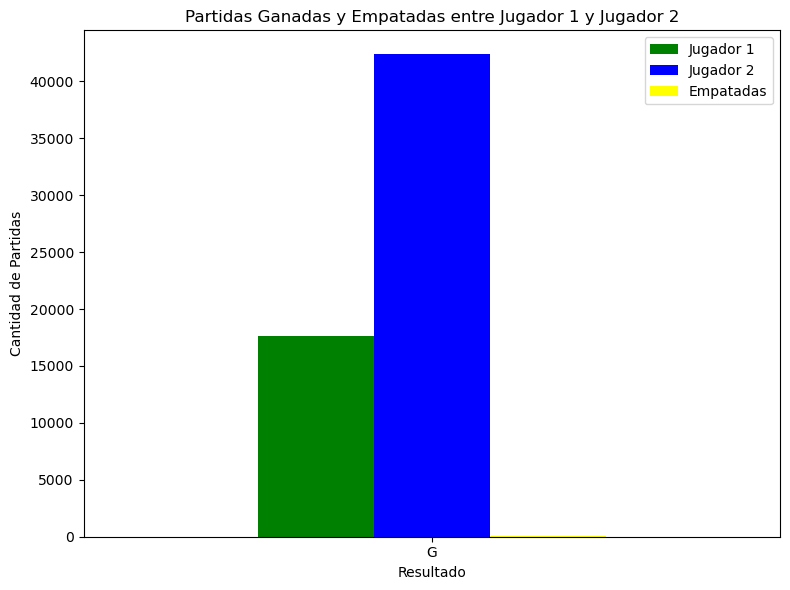

Q-table saved successfully
Q-table saved successfully


In [25]:
tablero = Board.Connect4Board()

agente = Agent.Agent(tablero, "O",epsilon=0.9,alpha=0.8,gamma=2)
otroAgente = Agent.Agent(tablero, "X")
juego = AgentVsAgent(tablero, agente, otroAgente, epochs = 60000)
juego.play(plot_result=False)

**Prueba contra un agente aleatorio**

Q_Table_A2_30k_epsilon_09_alpha_08_gamma_2.pkl
Q-table load successfull
Epoch # 0 took 0.045 s
Epoch # 1 took 0.046 s
Epoch # 2 took 0.028 s
Epoch # 3 took 0.029 s
Epoch # 4 took 0.046 s
Epoch # 5 took 0.043 s
Epoch # 6 took 0.017 s
Epoch # 7 took 0.042 s
Epoch # 8 took 0.059 s
Epoch # 9 took 0.039 s
Epoch # 10 took 0.032 s
Epoch # 11 took 0.089 s
Epoch # 12 took 0.055 s
Epoch # 13 took 0.036 s
Epoch # 14 took 0.023 s
Epoch # 15 took 0.044 s
Epoch # 16 took 0.033 s
Epoch # 17 took 0.013 s
Epoch # 18 took 0.055 s
Epoch # 19 took 0.056 s
Epoch # 20 took 0.021 s
Epoch # 21 took 0.031 s
Epoch # 22 took 0.064 s
Epoch # 23 took 0.047 s
Epoch # 24 took 0.025 s
Epoch # 25 took 0.048 s
Epoch # 26 took 0.048 s
Epoch # 27 took 0.054 s
Epoch # 28 took 0.064 s
Epoch # 29 took 0.057 s
Epoch # 30 took 0.018 s
Epoch # 31 took 0.053 s
Epoch # 32 took 0.058 s
Epoch # 33 took 0.036 s
Epoch # 34 took 0.019 s
Epoch # 35 took 0.066 s
Epoch # 36 took 0.055 s
Epoch # 37 took 0.063 s
Epoch # 38 took 0.022 s
Ep

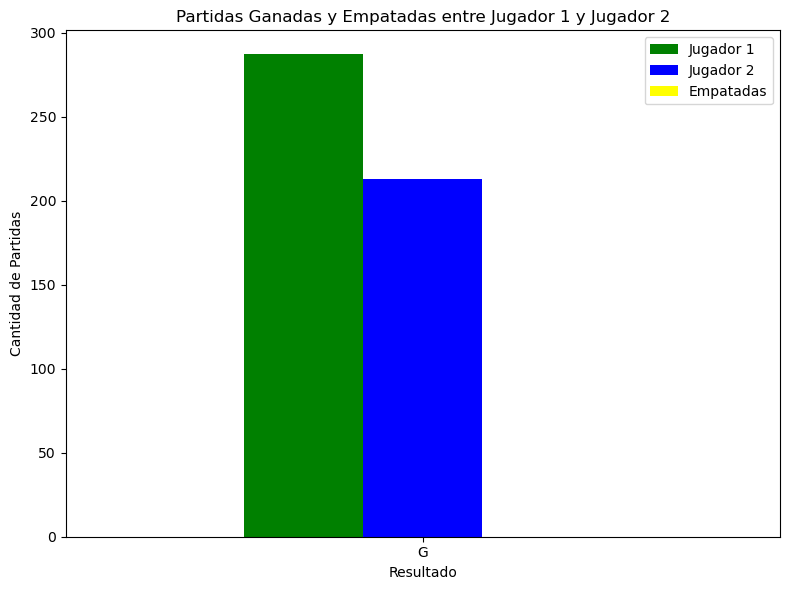

In [33]:
tablero = Board.Connect4Board()
agenteCarga = Agent.Agent(tablero, "O", filename = 'Q_Table_A2_30k_epsilon_09_alpha_08_gamma_2.pkl')
agenteAleatorio = Agent.Agent(tablero, "X", is_random = True)
juego = AgentVsAgent(tablero, agenteCarga, agenteAleatorio, epochs = 500)
juego.play(save_learning = False, plot_result = False, plot_result_by_bar = True)

**Aleatorio VS Aleatorio**

Epoch # 0 took 0.074 s
Epoch # 1 took 0.040 s
Epoch # 2 took 0.033 s
Epoch # 3 took 0.034 s
Epoch # 4 took 0.069 s
Epoch # 5 took 0.019 s
Epoch # 6 took 0.033 s
Epoch # 7 took 0.048 s
Epoch # 8 took 0.081 s
Epoch # 9 took 0.047 s
Epoch # 10 took 0.063 s
Epoch # 11 took 0.043 s
Epoch # 12 took 0.030 s
Epoch # 13 took 0.037 s
Epoch # 14 took 0.037 s
Epoch # 15 took 0.023 s
Epoch # 16 took 0.051 s
Epoch # 17 took 0.032 s
Epoch # 18 took 0.042 s
Epoch # 19 took 0.016 s
Epoch # 20 took 0.049 s
Epoch # 21 took 0.094 s
Epoch # 22 took 0.068 s
Epoch # 23 took 0.038 s
Epoch # 24 took 0.054 s
Epoch # 25 took 0.039 s
Epoch # 26 took 0.058 s
Epoch # 27 took 0.054 s
Epoch # 28 took 0.050 s
Epoch # 29 took 0.089 s
Epoch # 30 took 0.051 s
Epoch # 31 took 0.028 s
Epoch # 32 took 0.063 s
Epoch # 33 took 0.067 s
Epoch # 34 took 0.020 s
Epoch # 35 took 0.066 s
Epoch # 36 took 0.016 s
Epoch # 37 took 0.054 s
Epoch # 38 took 0.029 s
Epoch # 39 took 0.063 s
Epoch # 40 took 0.023 s
Epoch # 41 took 0.023 s
Ep

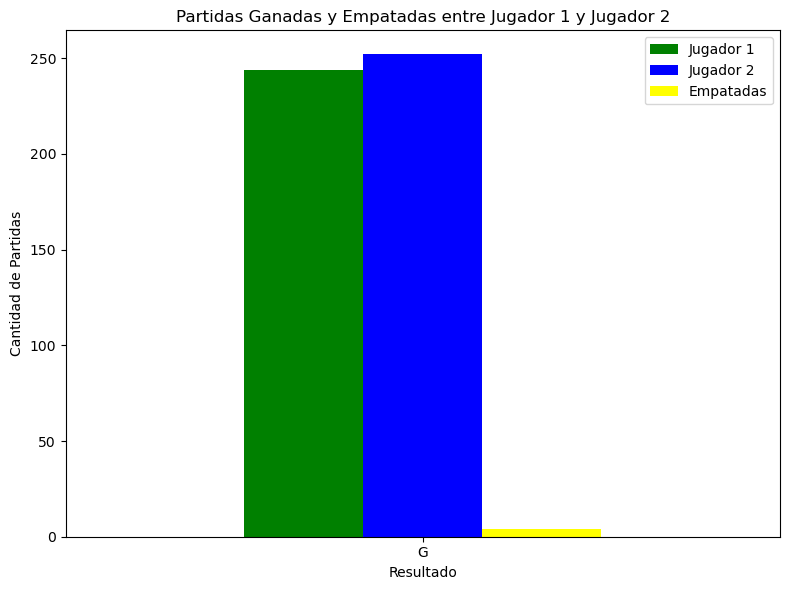

In [36]:
tablero = Board.Connect4Board()
agenteAleatorio1 = Agent.Agent(tablero, "O", is_random = True)
agenteAleatorio2 = Agent.Agent(tablero, "X", is_random = True)
juego = AgentVsAgent(tablero, agenteAleatorio1, agenteAleatorio2, epochs = 500)
juego.play(save_learning = False, plot_result = False, plot_result_by_bar = True)

**Prueba Mejor Agente VS Humano**

In [43]:
tablero = Board.Connect4Board()
agenteCarga = Agent.Agent(tablero, "O", filename = 'Q_Table_A2_30k_epsilon_09_alpha_08_gamma_2.pkl')
juego = PlayerVsAgent(tablero, agenteCarga)
juego.play()

Q_Table_A2_30k_epsilon_09_alpha_08_gamma_2.pkl
Q-table load successfull
I will start this time

It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     -     -     -     -     -
4     -     -     -     -     -     -     -
5     O     -     -     -     -     -     -


It´s your turn!


What is your move?  X


invalid literal for int() with base 10: 'X'


What is your move?  3



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     -     -     -     -     -
4     -     -     -     -     -     -     -
5     O     -     X     -     O     -     -


It´s your turn!


What is your move?  2



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     -     -     -     -     -
4     -     O     -     -     -     -     -
5     O     X     X     -     O     -     -


It´s your turn!


What is your move?  1



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     -     -     -     -     -
4     X     O     -     -     -     -     -
5     O     X     X     O     O     -     -


It´s your turn!


What is your move?  3



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     O     -     -     -     -
4     X     O     X     -     -     -     -
5     O     X     X     O     O     -     -


It´s your turn!


What is your move?  4



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     O     O     -     -     -
4     X     O     X     X     -     -     -
5     O     X     X     O     O     -     -


It´s your turn!


What is your move?  5



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     O     O     O     -     -
4     X     O     X     X     X     -     -
5     O     X     X     O     O     -     -


It´s your turn!


What is your move?  7



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     -     -     -
3     -     -     O     O     O     -     -
4     X     O     X     X     X     -     O
5     O     X     X     O     O     -     X


It´s your turn!


What is your move?  6



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     O     -     -
3     -     -     O     O     O     -     -
4     X     O     X     X     X     -     O
5     O     X     X     O     O     X     X


It´s your turn!


What is your move?  2



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     -     -     O     -     -
3     -     X     O     O     O     -     -
4     X     O     X     X     X     O     O
5     O     X     X     O     O     X     X


It´s your turn!


What is your move?  3



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     -     X     -     O     -     -
3     -     X     O     O     O     -     O
4     X     O     X     X     X     O     O
5     O     X     X     O     O     X     X


It´s your turn!


What is your move?  7



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     -
2     -     O     X     -     O     -     X
3     -     X     O     O     O     -     O
4     X     O     X     X     X     O     O
5     O     X     X     O     O     X     X


It´s your turn!


What is your move?  7



It´s My turn!


        <<<<<<<<   CONNECT4  >>>>>>>>
  Col_1 Col_2 Col_3 Col_4 Col_5 Col_6 Col_7
0     -     -     -     -     -     -     -
1     -     -     -     -     -     -     X
2     -     O     X     O     O     -     X
3     -     X     O     O     O     -     O
4     X     O     X     X     X     O     O
5     O     X     X     O     O     X     X


YOU LOSE!


Do you want to play again? (y/n):  n


Thanks for playing, Bye!
